In [1]:
import numpy as np
import scipy
from scipy.fft import fft2, ifft2
import matplotlib.pyplot as plt

In [126]:
# Initialize x-y mesh
x = np.linspace(-10, 10, 64, endpoint=False)
y = np.linspace(-10, 10, 64, endpoint=False)
X, Y = np.meshgrid(x, y)

# Define initial conditions
m = 1
alpha = 0
n = 64
u = (np.tanh(np.sqrt(X**2 + Y**2)) - alpha)*np.cos(m*np.angle(X + 1j*Y) - np.sqrt(X**2 + Y**2))
v = (np.tanh(np.sqrt(X**2 + Y**2)) - alpha)*np.sin(m*np.angle(X + 1j*Y) - np.sqrt(X**2 + Y**2))
A1 = X
A2 = u

# Transform into Fourier domain
u0 = fft2(u)
v0 = fft2(v)
A3 = u0.real

vec0_new = np.hstack([(u0.reshape(n*n), v0.reshape(n*n))])

# Append initial conditions
u0 = u0.reshape(-1, 1, order='F')
v0 = v0.reshape(-1, 1, order='F')
vec0 = np.concatenate((u0, v0))
A4 = vec0.imag

def rhs1(t, n, vec, beta, KX, KY):
    """Right-hand side function to return Fourier transform of the solution"""
    u_hat = vec[:4096].reshape(n, n, order='F')
    v_hat = vec[4096:].reshape(n, n, order='F')

    # Transform out of Fourier domain
    u = ifft2(u_hat)
    v = ifft2(v_hat)

    u_nl = u - u**3 - u*v**2 + beta*(v*u**2 + v**3)
    v_nl = -beta*(u**3 + u*v**2) + v - v*u**2 - v**3

    u_t = fft2(u_nl) - 0.1*((KX**2)*u_hat + (KY**2)*u_hat)
    v_t = fft2(v_nl) - 0.1*((KX**2)*v_hat + (KY**2)*v_hat)

    u_t = u_t.reshape(n**2, order='F')
    v_t = v_t.reshape(n**2, order='F')
    rhs = np.concatenate((u_t, v_t), axis=0)

    return rhs

In [127]:
X

array([[-10.    ,  -9.6875,  -9.375 , ...,   9.0625,   9.375 ,   9.6875],
       [-10.    ,  -9.6875,  -9.375 , ...,   9.0625,   9.375 ,   9.6875],
       [-10.    ,  -9.6875,  -9.375 , ...,   9.0625,   9.375 ,   9.6875],
       ...,
       [-10.    ,  -9.6875,  -9.375 , ...,   9.0625,   9.375 ,   9.6875],
       [-10.    ,  -9.6875,  -9.375 , ...,   9.0625,   9.375 ,   9.6875],
       [-10.    ,  -9.6875,  -9.375 , ...,   9.0625,   9.375 ,   9.6875]])

In [128]:
t_span = np.linspace(0, 4, 9)
t_span

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ])

In [129]:
np.squeeze(vec0).shape

(8192,)

In [130]:
vec0_new.shape

(2, 4096)

In [131]:
t_span = np.linspace(0, 4, 9)
r1 = np.arange(0, n/2, 1)
r2 = np.arange(-n/2, 0, 1)
kx = (2*np.pi/20)*np.concatenate((r1, r2))
ky = kx.copy()
KX, KY = np.meshgrid(kx, ky)
beta = 1

# Timestep using the explicit Runge-Kutta method of order 4(5)
sol1 = scipy.integrate.solve_ivp(lambda t, vec: rhs1(t, n, vec, beta, KX, KY), [0, 4], np.squeeze(vec0), t_eval = t_span)
A5 = sol1.y.real
A6 = sol1.y.imag
A7 = sol1.y.real[:4096][:, 4].reshape(-1, 1)
A8 = sol1.y.real[:4096][:, 4].reshape(n, n, order='F')
A9 = ifft2(sol1.y[:4096][:, 4].reshape(n, n, order='F')).real
A9

array([[ 0.04736064,  0.28133149,  0.40533858, ..., -0.39682142,
        -0.3207424 , -0.16293972],
       [-0.35052829, -0.04875761,  0.12279245, ..., -0.72544528,
        -0.70229182, -0.59007818],
       [-0.55427268, -0.2701817 , -0.10639557, ..., -0.8698788 ,
        -0.86781795, -0.77714496],
       ...,
       [ 0.86154337,  0.92296386,  0.9143369 , ...,  0.47410608,
         0.55025144,  0.71735188],
       [ 0.77718833,  0.85307907,  0.85788894, ...,  0.28891867,
         0.40292024,  0.6114546 ],
       [ 0.51541845,  0.63887318,  0.68372814, ..., -0.00172152,
         0.12407574,  0.33709663]])

In [132]:
sol1.y

array([[ 24.94003847+0.00000000e+00j,  12.73268299-1.11053201e-15j,
         -1.38095598-2.32314163e-16j, ..., -64.02389647-1.46100786e-14j,
        -67.76356741-1.56109324e-14j, -61.18058974-1.99476748e-14j],
       [  0.99295252-1.42103578e+01j,  12.02949309-4.37375205e+01j,
         24.70184895-7.06089959e+01j, ...,  29.22746661-3.10063992e+01j,
          8.40670057+1.79896533e+01j, -18.5268817 +6.94221535e+01j],
       [ 32.80550386+1.70907884e+02j,  39.16999947+1.59554619e+02j,
         38.79066457+1.20157720e+02j, ..., -43.73006064-1.03164328e+02j,
        -63.43595573-1.29222009e+02j, -70.7356071 -1.32182907e+02j],
       ...,
       [-22.22413001-6.17577477e+02j, -15.02139101-6.49103907e+02j,
         -3.38551438-5.64160667e+02j, ...,  42.60088811+4.49555077e+02j,
         30.98002141+6.28860801e+02j,   8.04758007+6.88983996e+02j],
       [ -8.98445504-1.07662293e+02j,  -4.82476629-3.17538939e+02j,
         -0.75921268-4.66053832e+02j, ...,  32.2969229 -7.36519513e+01j,
       

In [33]:
def cheb(N):
    # N is the number of points in the interior.
    if N==0:
        D = 0
        x = 1
        return D, x
    vals = np.linspace(0, N, N+1)
    x = np.cos(np.pi*vals/N)
    x = x.reshape(-1, 1)
    c = np.ones(N-1)
    c = np.pad(c, (1,), constant_values = 2)
    c *= (-1)**vals
    c = c.reshape(-1, 1)
    X = np.tile(x, (1, N+1))
    dX = X-X.T                  
    D  = (c*(1/c.T))/(dX+(np.eye(N+1)))       #off-diagonal entries
    D  = D - np.diag(sum(D.T))                #diagonal entries

    return D, x

In [34]:
tspan = np.arange(0,4.5,0.5)
tspan

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ])

In [35]:
tspan = np.arange(0,4.5,0.5)

#Define the drag term
nu = 0.001
L=20
n=64

beta = 1
D1 = 0.1
D2 = 0.1

#Setup our x and y domain
x2 = np.linspace(-L/2,L/2,n+1) 
x=x2[0:-1] 
y=x.copy()

#Setup the x values.
r1=np.arange(0,n/2,1)
r2=np.arange(-n/2,0,1)
kx = (2*np.pi/L)*np.concatenate((r1,r2))
ky=kx.copy()

#Put X and Y on a meshgrid
[X,Y]=np.meshgrid(x,y)

#Do the same for the k values
[KX,KY]=np.meshgrid(kx,ky)

In [36]:
X, Y = np.meshgrid(x,y)
m = 1
alpha = 0

#initial conditions
u = (np.tanh(np.sqrt(X**2+Y**2))-alpha)*np.cos(m*np.angle(X+1j*Y) - np.sqrt(X**2+Y**2))
v = (np.tanh(np.sqrt(X**2+Y**2))-alpha)*np.sin(m*np.angle(X+1j*Y) - np.sqrt(X**2+Y**2))

In [37]:
# initial conditions in fourier space, vector form
U_hat_0 = fft2(u)
V_hat_0 = fft2(v)   

#converting to a vector because to send to the solver
U_hat_0_vec = U_hat_0.reshape(n**2,order= 'F')
V_hat_0_vec = V_hat_0.reshape(n**2,order= 'F')

In [38]:
init_vec = np.concatenate((U_hat_0_vec,V_hat_0_vec),axis=0).squeeze()

In [51]:
init_vec

array([ 24.94003847  -0.j        ,   0.99295252 -14.21035779j,
        32.80550386+170.90788411j, ..., -22.22413001-617.57747653j,
        -8.98445504-107.66229252j,  -6.4753501  +39.62454543j])

In [39]:
def vortrhs(t, vec, D1, D2, beta, n, KX, KY):
    # Reshape the Fourier-transformed vector
    # into an nxn matrix
    u_double_hat = vec[0:4096].reshape(n, n,order= 'F')
    v_double_hat = vec[4096:8192].reshape(n, n, order= 'F')
    
    #Write all of the terms in the physical space
    u = np.real(ifft2(u_double_hat))
    v = np.real(ifft2(v_double_hat))
    #need fourier transformed data--->u_double_hat
    
    #calculate a, lambda, omega (vectors)
    A_2 = u**2 + v**2
    lambda_A = 1 - A_2
    omega_A = -beta*A_2
    
    #print("A_2", np.shape(A_2))
    #print("lambda_A", np.shape(lambda_A))
    #print("omega_A", np.shape(omega_A))
    
    #calculate u_t and v_t
    # Ut= λ(A)U −ω(A)V + D1∇2U
    # Vt= ω(A)U −λ(A)V + D2∇2V
    
    NL_u = lambda_A*u - omega_A*v 
    NL_v = omega_A*u - lambda_A*v
    
    #print("NL_u", np.shape(NL_u))
    #print("NL_u", np.shape(NL_u))
    
    u_t = fft2(NL_u) + D1*(-(KX**2)*u_double_hat-(KY**2)*u_double_hat)
    v_t = fft2(NL_v) + D2*(-(KX**2)*v_double_hat-(KY**2)*v_double_hat)
    
    #print("u_t", np.shape(u_t))
    #print("v_t", np.shape(v_t))
    
    #Convert everything back and return a vector in the Fourier space.
    u_t_col = u_t.reshape(n**2,order= 'F')
    v_t_col = v_t.reshape(n**2,order= 'F')
    
    #print("u_t_col", np.shape(u_t_col))
    #print("v_t_col", np.shape(v_t_col))
    
    rhs = np.concatenate([u_t_col,v_t_col],axis=0).squeeze()
    #print(np.shape(rhs))

    return rhs

In [59]:
tspan

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ])

In [56]:
sol = scipy.integrate.solve_ivp(lambda t,wfvec: vortrhs(t, wfvec, D1, D2, beta, n, KX, KY),[0, 4], init_vec, t_eval = tspan, method="RK45")


In [57]:
np.shape(sol.y)

(8192, 9)

In [58]:
print(sol.y)

[[ 24.94003847  +0.j          14.72192649  +0.j
    9.55562266  +0.j         ...  15.17001106  +0.j
    8.94662737  +0.j          -0.57774886  +0.j        ]
 [  0.99295252 -14.21035779j  12.14615028 -42.80583303j
   25.25541582 -67.47187663j ...  40.13571383-110.37202815j
   31.59735402-120.19259881j  23.61533867-134.8218486j ]
 [ 32.80550386+170.90788411j  40.47244894+156.10011109j
   45.97767713+111.19057481j ...  30.587257   -56.98785424j
   21.42169533 -67.92258777j  14.39372465 -71.74262202j]
 ...
 [-22.22413001-617.57747653j -14.89950082-605.23207147j
   -5.16660928-452.83716236j ...  26.32893956+247.59958679j
   25.71333982+311.2803757j   21.91465224+337.54647103j]
 [ -8.98445504-107.66229252j  -3.69002318-293.83526159j
    0.99129979-385.76955485j ...  20.9178813 -117.17927412j
   23.00162724 -13.93735101j  21.92143991 +68.04140593j]
 [ -6.4753501  +39.62454543j  11.75077744 -40.41372739j
   25.32031269-108.28046644j ...  37.23168958-155.10157588j
   33.31585657-119.38281254j  

In [54]:
np.real(ifft2(sol.y[0:4096,4].reshape(64,64).T))

array([[-0.17699565, -0.24522142, -0.30398464, ...,  0.21027749,
         0.05597145, -0.07880072],
       [-0.54022951, -0.49994467, -0.45382622, ..., -0.20307974,
        -0.40206783, -0.51868589],
       [-0.66655957, -0.56399805, -0.47436346, ..., -0.44930733,
        -0.63047386, -0.70474882],
       ...,
       [ 0.77838514,  0.71908594,  0.5498074 , ...,  0.62259227,
         0.66268678,  0.73918507],
       [ 0.66811202,  0.57607898,  0.3901264 , ...,  0.60770366,
         0.63384414,  0.67230737],
       [ 0.33564784,  0.20653029,  0.03861621, ...,  0.51491698,
         0.47107155,  0.41874119]])

In [43]:
tspan[8]

4.0

(64, 64)


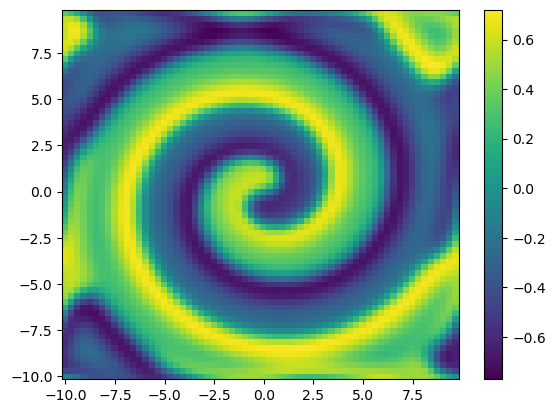

In [44]:
[X,Y]=np.meshgrid(x,y)
#tspan[8] =25
z = np.real(ifft2(sol.y[0:4096,8].reshape(64,64)))
print(np.shape(z))

# Generate the plot
fig, ax = plt.subplots()
cmap = ax.pcolor(X, Y, z.T)
fig.colorbar(cmap)
plt.show(fig)

# Problem 2

In [133]:
# Define initial conditions
m = 1
alpha = 0
n = 30

# Create the Chebyshev differentiation matrix
[D, x] = cheb(n)

D[n,:]=0
D[0,:]=0

x = 10*x.reshape(n + 1)
D2 = D@D
D2 = D2[1:-1, 1:-1]/100

# Scale Laplacian
I = np.eye(len(D2))
Lap = np.kron(D2, I) + np.kron(I, D2)
A10 = Lap

# Create the Chebyshev points
x2 = x[1:-1]
y2 = x2.copy()
[X, Y] = np.meshgrid(x2, y2)
A11 = Y

In [134]:
x

array([ 1.00000000e+01,  9.94521895e+00,  9.78147601e+00,  9.51056516e+00,
        9.13545458e+00,  8.66025404e+00,  8.09016994e+00,  7.43144825e+00,
        6.69130606e+00,  5.87785252e+00,  5.00000000e+00,  4.06736643e+00,
        3.09016994e+00,  2.07911691e+00,  1.04528463e+00,  2.83276945e-15,
       -1.04528463e+00, -2.07911691e+00, -3.09016994e+00, -4.06736643e+00,
       -5.00000000e+00, -5.87785252e+00, -6.69130606e+00, -7.43144825e+00,
       -8.09016994e+00, -8.66025404e+00, -9.13545458e+00, -9.51056516e+00,
       -9.78147601e+00, -9.94521895e+00, -1.00000000e+01])

In [135]:
u = (np.tanh(np.sqrt(X**2 + Y**2)) - alpha)*np.cos(m*np.angle(X + 1j*Y) - np.sqrt(X**2 + Y**2))
v = (np.tanh(np.sqrt(X**2 + Y**2)) - alpha)*np.sin(m*np.angle(X + 1j*Y) - np.sqrt(X**2 + Y**2))
A12 = v

# Append initial conditions
u = u.reshape(-1, 1, order='F')
v = v.reshape(-1, 1, order='F')
vec1 = np.concatenate((u, v), axis=0)
A13 = vec1

def rhs2(t, vec, beta, Lap):
    """"Right-hand side function to solve our PDE"""
    u = vec[:841]
    v = vec[841:]

    u_nl = u - u**3 - u*v**2 + beta*(v*u**2 + v**3)
    v_nl = -beta*(u**3 + u*v**2) + v - v*u**2 - v**3

    u_t = u_nl + 0.1*(Lap@u)
    v_t = v_nl + 0.1*(Lap@v)

    rhs = np.concatenate((u_t, v_t), axis=0)

    return rhs

# Timestep using the explicit Runge-Kutta method of order 4(5)
sol2 = scipy.integrate.solve_ivp(lambda t, vec: rhs2(t, vec, beta, Lap), [0, 4], np.squeeze(vec1), t_eval = t_span)
A14 = sol2.y.T
A15 = sol2.y.real[841:][:, 4].reshape(-1, 1)
A16 = np.pad(A15.reshape(29, 29).T, [1, 1])
A16[:5, :5]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.68471467, -0.085779  , -0.81326731, -0.31499556],
       [ 0.        , -0.14735469, -0.00770236, -0.14974624,  0.01195816],
       [ 0.        , -0.88981786, -0.09971142, -1.01935008, -0.28842487],
       [ 0.        , -0.36715919, -0.02147719, -0.36065585,  0.09750604]])

In [136]:
sol2.y

array([[ 0.75647181,  0.52765233,  0.11675198, ..., -0.53478999,
        -0.62611813, -0.68971386],
       [ 0.82199448,  0.2222233 ,  0.13105715, ...,  0.03317781,
        -0.00446252, -0.04361551],
       [ 0.90841565,  0.7092191 ,  0.30396861, ..., -0.47059638,
        -0.61951565, -0.74305013],
       ...,
       [ 0.41806819,  0.98134305,  0.95457224, ...,  0.75143497,
         0.63408637,  0.48350803],
       [ 0.56949545,  0.10849561,  0.11426712, ...,  0.17706329,
         0.18161147,  0.17763674],
       [ 0.6540263 ,  0.85194401,  0.81705692, ...,  0.49204585,
         0.36539111,  0.21951829]])

In [102]:
sol2.y

array([[ 0.75647181,  0.52765233,  0.11675198, ..., -0.53478999,
        -0.62611813, -0.68971386],
       [ 0.82199448,  0.2222233 ,  0.13105715, ...,  0.03317781,
        -0.00446252, -0.04361551],
       [ 0.90841565,  0.7092191 ,  0.30396861, ..., -0.47059638,
        -0.61951565, -0.74305013],
       ...,
       [ 0.41806819,  0.98134305,  0.95457224, ...,  0.75143497,
         0.63408637,  0.48350803],
       [ 0.56949545,  0.10849561,  0.11426712, ...,  0.17706329,
         0.18161147,  0.17763674],
       [ 0.6540263 ,  0.85194401,  0.81705692, ...,  0.49204585,
         0.36539111,  0.21951829]])

In [71]:
sol2.y.real

array([[0.75647181, 0.02228799, 0.01418528, ..., 0.00868623, 0.00820802,
        0.00788648],
       [0.82199448, 0.08117934, 0.05349657, ..., 0.03330952, 0.03162555,
        0.0305786 ],
       [0.90841565, 0.13632203, 0.09786904, ..., 0.06356308, 0.06056539,
        0.05880733],
       ...,
       [0.41806819, 0.0391491 , 0.02403323, ..., 0.01452102, 0.01272898,
        0.01108075],
       [0.56949545, 0.02386379, 0.01160329, ..., 0.00612753, 0.00538321,
        0.00468505],
       [0.6540263 , 0.0063559 , 0.00285956, ..., 0.00154244, 0.00134664,
        0.0011808 ]])